Extracted contents to /content/nyc311_data
Loading: /content/nyc311_data/nyc311Export1/#1.csv
Loading: /content/nyc311_data/nyc311Export1/#2.csv
Total rows: 1699981
DataFrame columns: ['unique_key', 'created_date', 'closed_date', 3, 4, 5, 6, 7, 8, 9, 'complaint_type', 11, 'borough', 13, 'incident_zip', 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
<class 'pandas.core.frame.DataFrame'>
Index: 1572495 entries, 13 to 1696065
Data columns (total 50 columns):
 #   Column          Non-Null Count    Dtype              
---  ------          --------------    -----              
 0   unique_key      1572495 non-null  int64              
 1   created_date    1572495 non-null  datetime64[ns, UTC]
 2   closed_date     1572495 non-null  datetime64[ns, UTC]
 3   3               1572495 non-null  object             
 4   4               1572495 non-null  object             
 5   5               1572494 non-null  object         

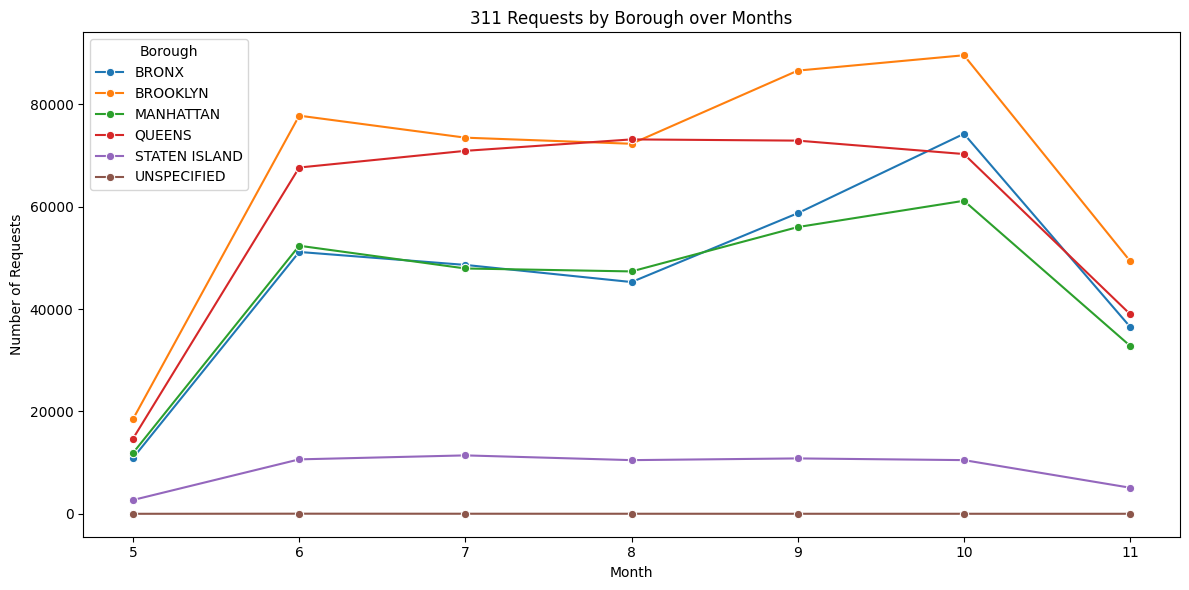

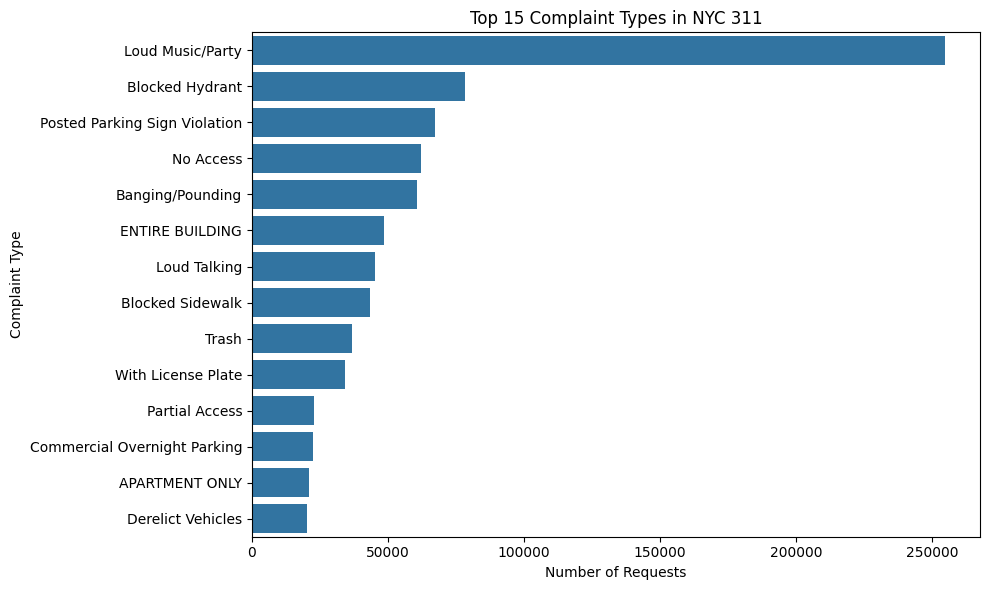

--2025-12-04 10:14:50--  https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42168371 (40M) [text/plain]
Saving to: ‘/content/nyc_zipcodes.geojson’

/content/nyc_zipcod 100%[===================>]  40.21M   200MB/s    in 0.2s    

2025-12-04 10:14:50 (200 MB/s) - ‘/content/nyc_zipcodes.geojson’ saved [42168371/42168371]

Downloaded nyc_zipcodes.geojson to /content/
Properties of the first GeoJSON feature:
{'STATEFP10': '36', 'ZCTA5CE10': '12205', 'GEOID10': '3612205', 'CLASSFP10': 'B5', 'MTFCC10': 'G6350', 'FUNCSTAT10': 'S', 'ALAND10': 40906445, 'AWATER10': 243508, 'INTPTLAT10': '+42.7187855', 'INTPTLON10': '-073.8292399', 'PARTFLG10': 'N'}
MANHATTAN n, m

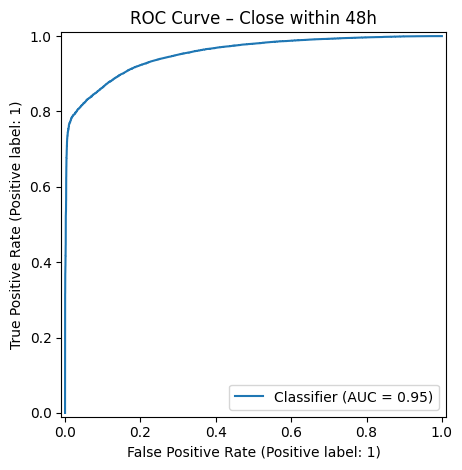

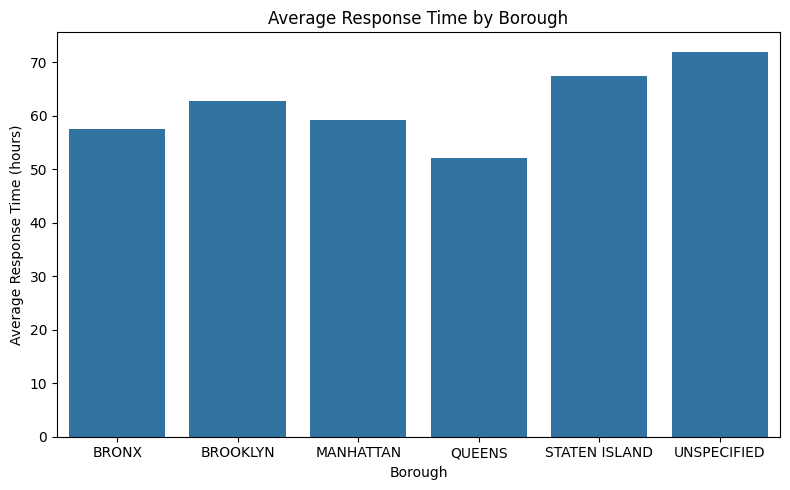

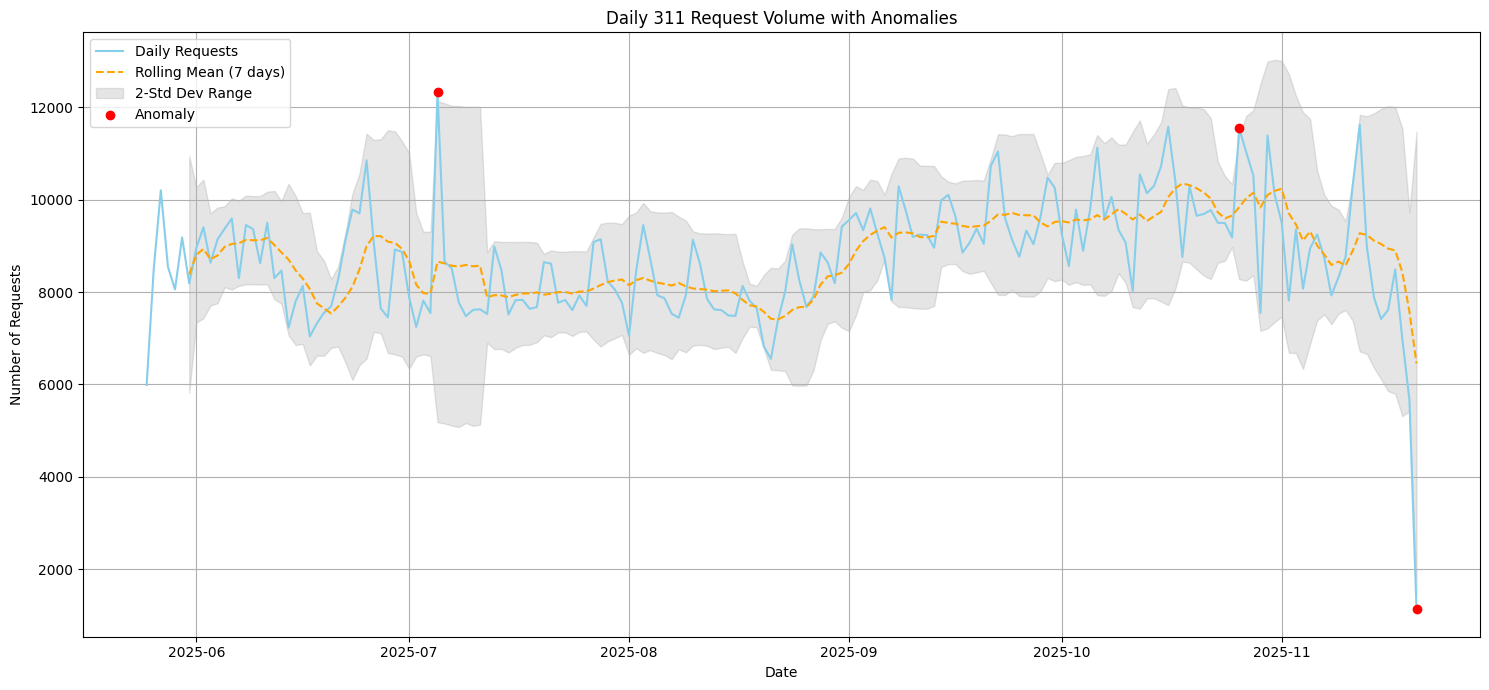

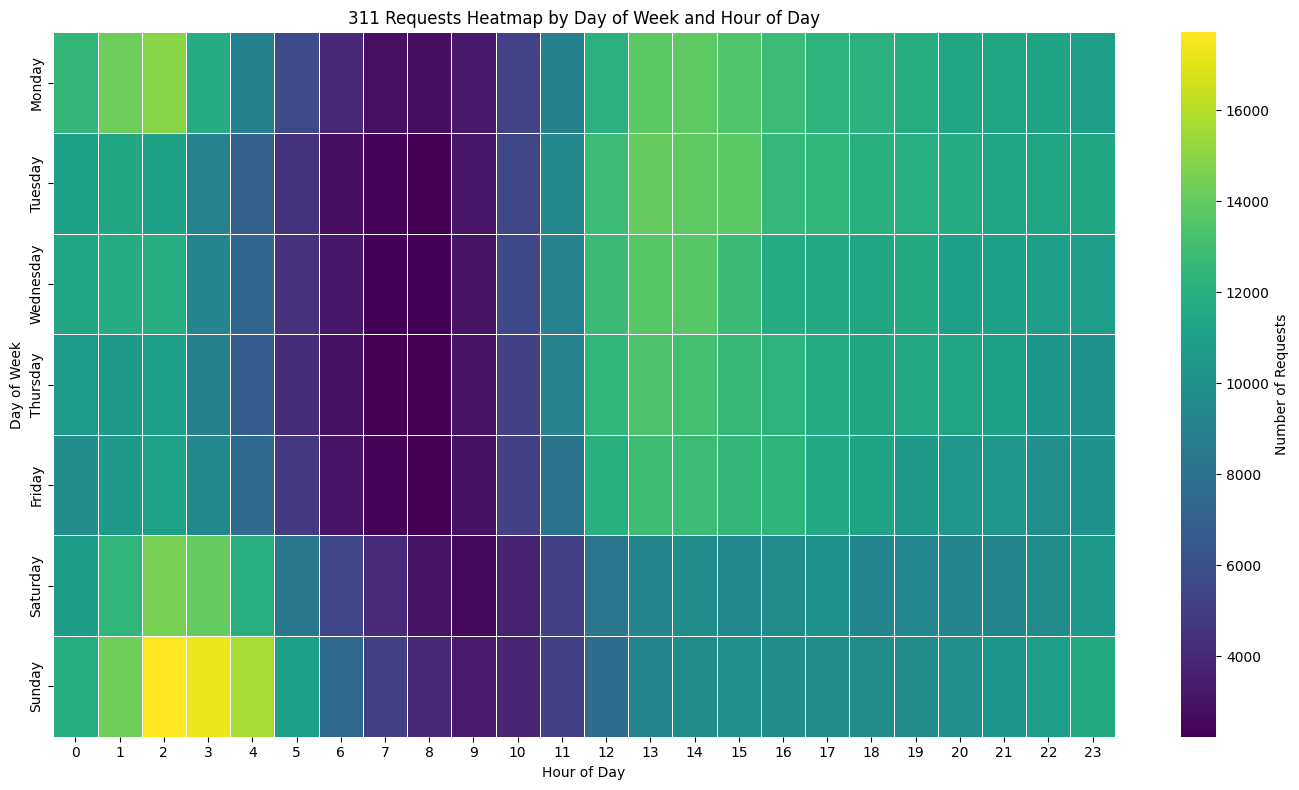

Shape of the filtered DataFrame (noise_complaints_df): (361025, 51)

Noise Complaints by Borough:
         borough  n_noise_complaints
0          BRONX              110933
1       BROOKLYN               94082
2      MANHATTAN               76568
3         QUEENS               71294
4  STATEN ISLAND                8138
5    UNSPECIFIED                  10


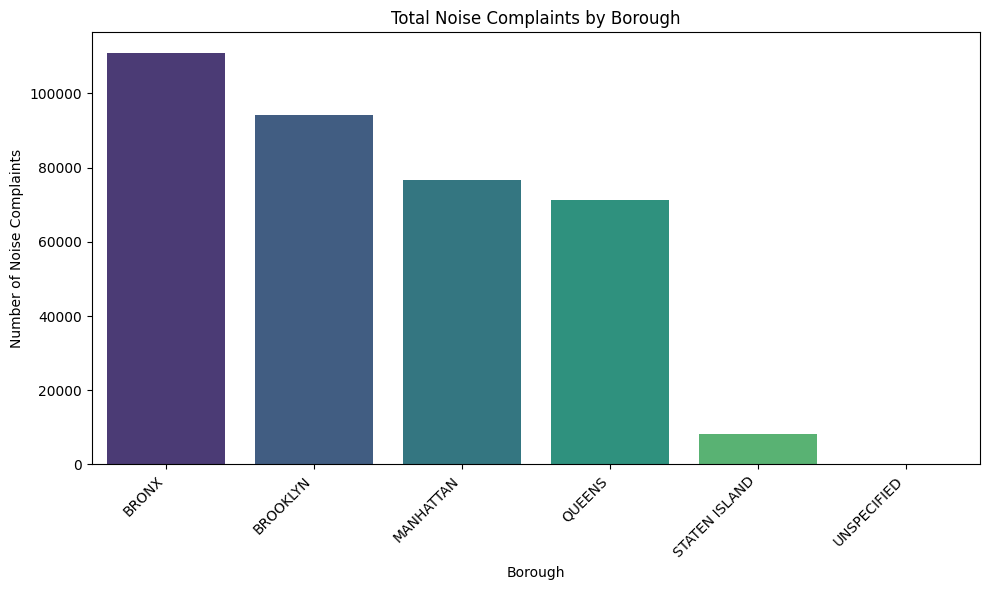


The borough with the highest number of noise complaints is BRONX with 110933 complaints.
This suggests that BRONX should receive additional enforcement resources to address noise-related issues.


/tmp/ipython-input-505529724.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofweek', y='response_hours', order=day_order, palette='viridis')


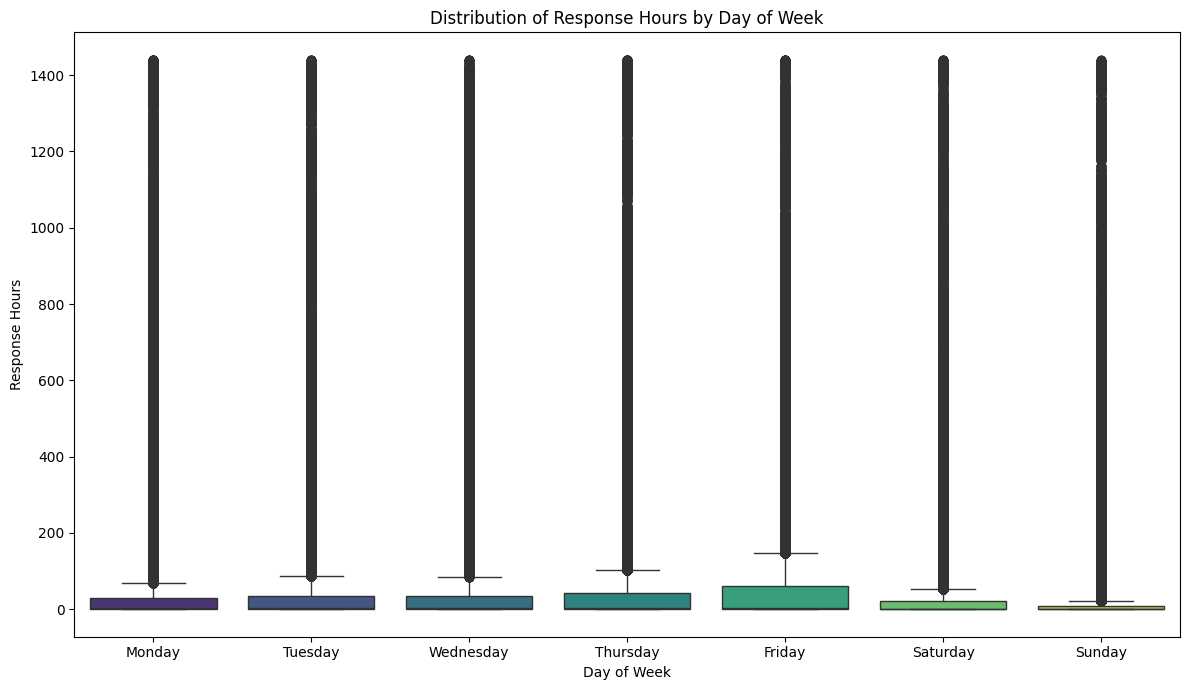

/tmp/ipython-input-505529724.py:418: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df.sample(n=50000, random_state=42), x='hour', y='response_hours', inner='quartile', palette='coolwarm')


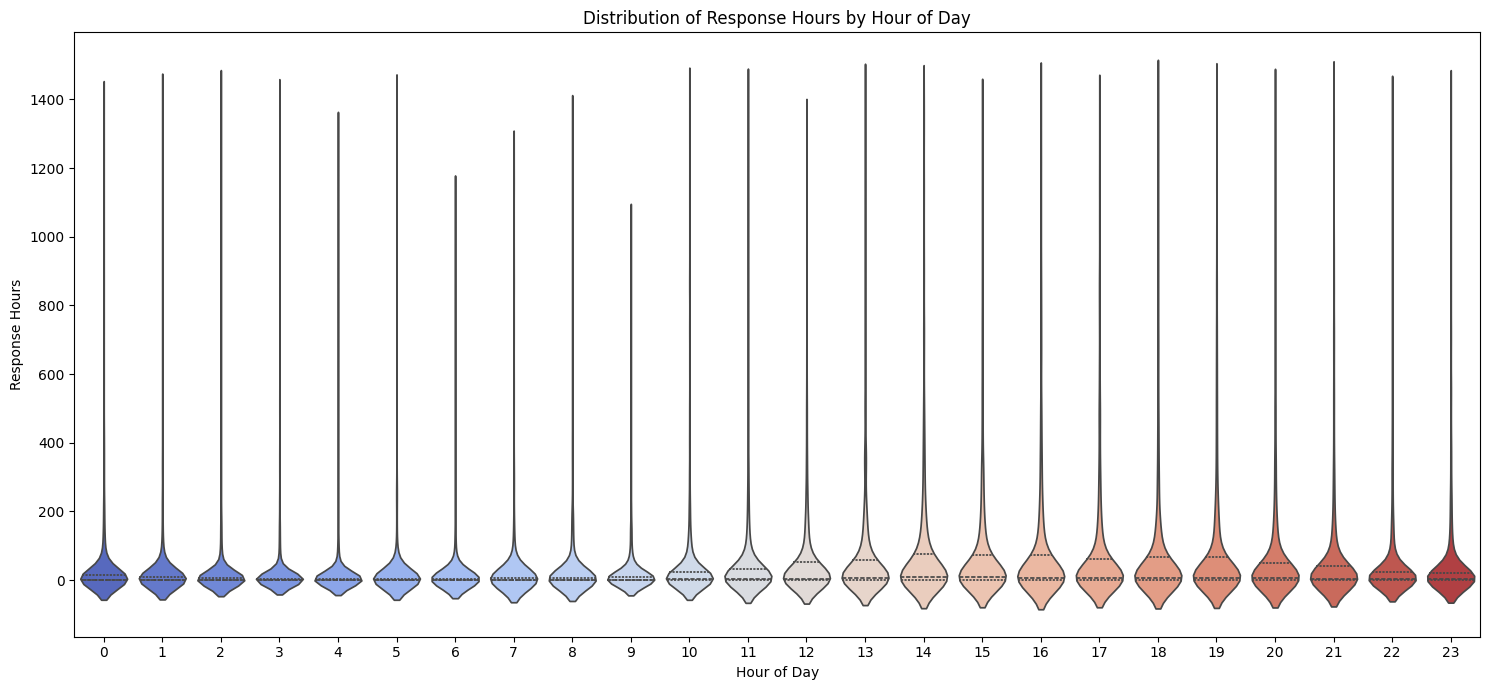

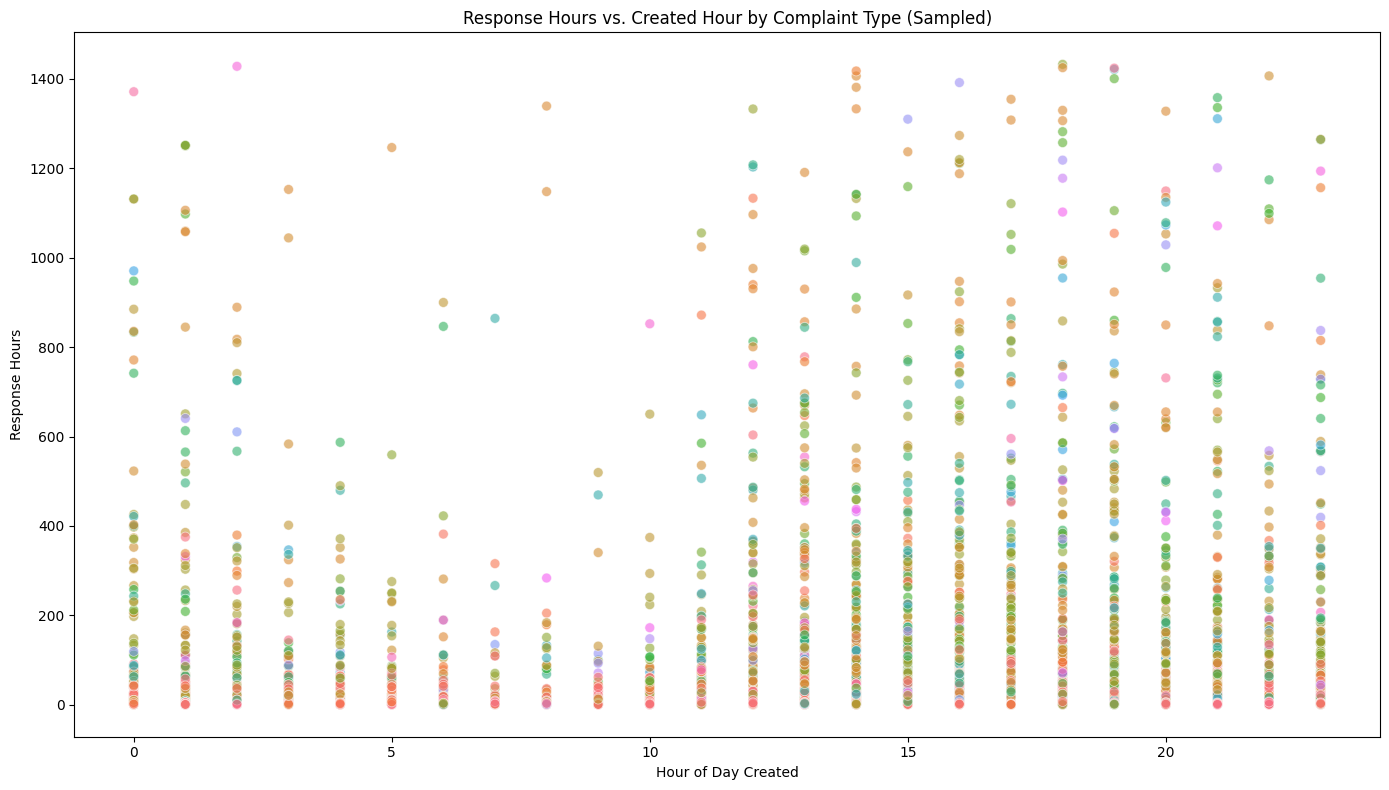

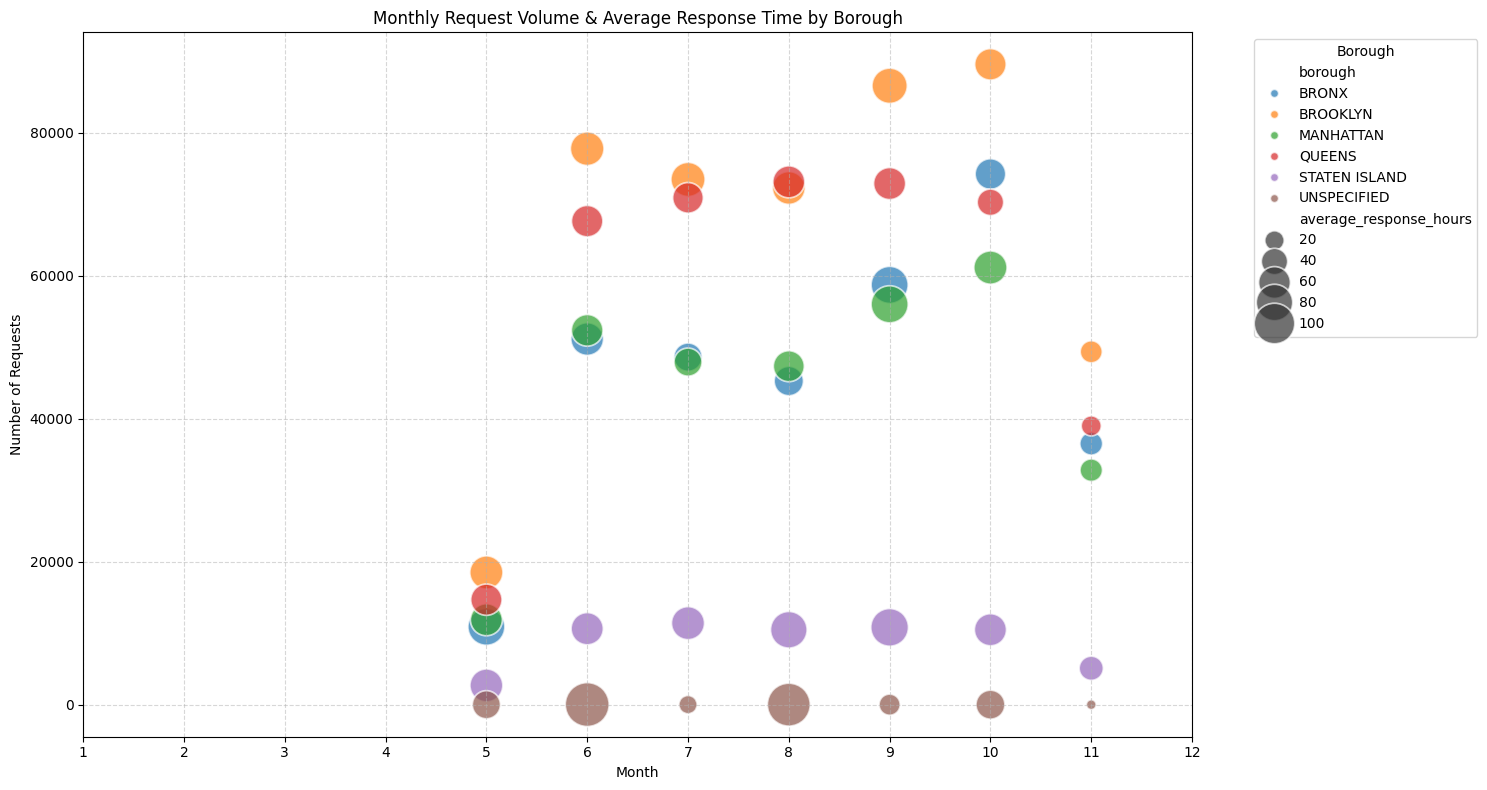

In [ ]:
# Core libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

# SQL engine and geospatial libraries
# Install necessary packages silently
!pip install duckdb folium geopandas shapely pyproj --quiet
import duckdb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Statistics and Machine Learning libraries
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# File system and JSON handling
import glob
import zipfile
import os
import json


# --- Data Loading and Initial Preprocessing ---
# Define paths for zip file and extraction directory
zip_file_path = "/content/nyc311Export1.zip"
extract_dir = "/content/nyc311_data"

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f"Extracted contents to {extract_dir}")

# Find and load all CSV files into a single DataFrame
extracted_csv_files = sorted(glob.glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True))
dfs = []
for f in extracted_csv_files:
    print("Loading:", f)
    # Handle malformed rows and no header by default
    df_part = pd.read_csv(f, low_memory=False, on_bad_lines='skip', header=None)
    dfs.append(df_part)
df = pd.concat(dfs, ignore_index=True)
print("Total rows:", len(df))

# Rename columns based on observed data structure for NYC 311 dataset
df.rename(columns={
    0: "unique_key",
    1: "created_date",
    2: "closed_date",
    10: "complaint_type",
    12: "borough",
    14: "incident_zip"
}, inplace=True)
print("DataFrame columns:", df.columns.tolist())


# --- Feature Engineering and Data Cleaning ---
# Convert date columns to datetime objects, coercing errors and setting UTC
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce", utc=True)
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce", utc=True)

# Calculate response time in hours
df["response_hours"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 3600

# Filter out extreme outliers for response hours (e.g., beyond 60 days)
df = df[df["response_hours"].between(0, 24*60, inclusive="both")]

# Extract temporal features from created_date
df["year"] = df["created_date"].dt.year
df["month"] = df["created_date"].dt.month
df["dayofweek"] = df["created_date"].dt.day_name()
df["hour"] = df["created_date"].dt.hour

# Remove rows with missing location data (borough or incident_zip)
df = df[df["borough"].notna()]
df = df[df["incident_zip"].notna()]

df.info()


# --- DuckDB Integration ---
# Connect to DuckDB and register the DataFrame for SQL queries
con = duckdb.connect()
con.register("requests", df)


# --- Example Analysis 1: Complaints by Borough and Month ---
query_borough_month = """
SELECT
    borough,
    year,
    month,
    COUNT(*) AS n_requests
FROM requests
GROUP BY borough, year, month
ORDER BY year, month, borough
"""
bourough_month = con.execute(query_borough_month).df()

# Plotting complaints by borough over months
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=borough_month,
    x="month",
    y="n_requests",
    hue="borough",
    marker="o"
)
plt.title("311 Requests by Borough over Months")
plt.xlabel("Month")
plt.ylabel("Number of Requests")
plt.legend(title="Borough")
plt.tight_layout()
plt.show()


# --- Example Analysis 2: Top Complaint Types Citywide ---
query_complaints = """
SELECT
    complaint_type,
    COUNT(*) AS n_requests
FROM requests
GROUP BY complaint_type
ORDER BY n_requests DESC
LIMIT 15
"""
top_complaints = con.execute(query_complaints).df()

# Plotting top 15 complaint types
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_complaints,
    x="n_requests",
    y="complaint_type"
)
plt.title("Top 15 Complaint Types in NYC 311")
plt.xlabel("Number of Requests")
plt.ylabel("Complaint Type")
plt.tight_layout()
plt.show()


# --- GeoJSON Data Loading and Inspection ---
# Download the NYC ZIP codes GeoJSON file
!wget -O /content/nyc_zipcodes.geojson https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json
print("Downloaded nyc_zipcodes.geojson to /content/")

geojson_path = "/content/nyc_zipcodes.geojson"
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Print properties of the first feature to inspect keys
if geojson_data and "features" in geojson_data and len(geojson_data["features"]) > 0:
    first_feature_properties = geojson_data["features"][0]["properties"]
    print("Properties of the first GeoJSON feature:")
    print(first_feature_properties)
else:
    print("GeoJSON data is empty or malformed.")


# --- Choropleth Map by ZIP Code ---
# Aggregate requests by ZIP code using SQL
zip_summary = con.execute("""
SELECT
    CAST(incident_zip AS VARCHAR) AS zip,
    COUNT(*) AS n_requests
FROM requests
GROUP BY incident_zip
""").df()

# Center map on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=10, tiles="cartodbpositron")

# Create Choropleth layer
folium.Choropleth(
    geo_data="/content/nyc_zipcodes.geojson",
    name="Requests per ZIP",
    data=zip_summary,
    columns=["zip", "n_requests"],
    key_on="feature.properties.ZCTA5CE10",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of 311 Requests (6 months)"
).add_to(m)

folium.LayerControl().add_to(m)
m # Display the map


# --- Statistical Inference: Hypothesis Test + Confidence Interval ---
# Focus on two boroughs (MANHATTAN and BRONX)
sub = df[df["borough"].isin(["MANHATTAN", "BRONX"])].copy()
sub = sub.dropna(subset=["response_hours"])

man = sub.loc[sub["borough"] == "MANHATTAN", "response_hours"]
brx = sub.loc[sub["borough"] == "BRONX", "response_hours"]

print("MANHATTAN n, mean, std:", man.shape[0], man.mean(), man.std())
print("BRONX     n, mean, std:", brx.shape[0], brx.mean(), brx.std())

# Perform Welch's t-test (assumes unequal variances)
t_stat, p_value = stats.ttest_ind(man, brx, equal_var=False)
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Calculate mean difference and 95% confidence interval
diff = man.mean() - brx.mean()
se = np.sqrt(man.var(ddof=1)/len(man) + brx.var(ddof=1)/len(brx)) # Standard error (Welch approximation)
z = 1.96 # Z-score for 95% confidence
ci_low = diff - z*se
ci_high = diff + z*se

print(f"Mean difference (MANHATTAN - BRONX): {diff:.2f} hours")
print(f"95% CI: [{ci_low:.2f}, {ci_high:.2f}] hours")


# --- Predictive Model: Will a request be closed within 48 hours? ---
# Create target variable: 1 if closed within 48 hours, 0 otherwise
df["closed_within_48h"] = (df["response_hours"] <= 48).astype(int)

# Define features and target
features = ["borough", "complaint_type", "dayofweek", "hour"]
target = "closed_within_48h"
model_df = df[features + [target]].dropna()

# Sample data for performance if dataset is too large
model_df_sample = model_df.sample(n=200_000, random_state=42) if len(model_df) > 200_000 else model_df
X = model_df_sample[features]
y = model_df_sample[target]

# Define categorical and numerical features for preprocessing
cat_features = ["borough", "complaint_type", "dayofweek"]
num_features = ["hour"]

# Create a preprocessing pipeline with OneHotEncoder for categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features),
    ]
)

# Create a full machine learning pipeline with preprocessing and Logistic Regression
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, n_jobs=-1)) # n_jobs=-1 uses all available processors
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model, make predictions, and evaluate
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", auc)

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – Close within 48h")
plt.tight_layout()
plt.show()


# --- Visualization: Average Response Time by Borough ---
bourough_resp = df.groupby("borough", as_index=False)["response_hours"].mean()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=bourough_resp,
    x="borough",
    y="response_hours"
)
plt.title("Average Response Time by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Response Time (hours)")
plt.tight_layout()
plt.show()


# --- Visualization: Daily Request Volume with Anomaly Detection ---
# Aggregate requests by date
daily_requests = df.groupby(df['created_date'].dt.date).size().reset_index(name='n_requests')
daily_requests['created_date'] = pd.to_datetime(daily_requests['created_date'])
daily_requests = daily_requests.set_index('created_date')

# Calculate rolling mean and standard deviation for anomaly detection
window_size = 7 # 7-day rolling window for weekly patterns
daily_requests['rolling_mean'] = daily_requests['n_requests'].rolling(window=window_size).mean()
daily_requests['rolling_std'] = daily_requests['n_requests'].rolling(window=window_size).std()

# Define upper and lower bounds for anomalies (e.g., 2 standard deviations)
daily_requests['upper_bound'] = daily_requests['rolling_mean'] + (daily_requests['rolling_std'] * 2)
daily_requests['lower_bound'] = daily_requests['rolling_mean'] - (daily_requests['rolling_std'] * 2)

# Identify anomalies outside the 2-standard deviation range
daily_requests['anomaly'] = ((daily_requests['n_requests'] > daily_requests['upper_bound']) |
                             (daily_requests['n_requests'] < daily_requests['lower_bound']))

# Plotting the daily requests with anomalies highlighted
plt.figure(figsize=(15, 7))
plt.plot(daily_requests.index, daily_requests['n_requests'], label='Daily Requests', color='skyblue')
plt.plot(daily_requests.index, daily_requests['rolling_mean'], label=f'Rolling Mean ({window_size} days)', color='orange', linestyle='--')
plt.fill_between(
    daily_requests.index,
    daily_requests['lower_bound'],
    daily_requests['upper_bound'],
    color='gray', alpha=0.2, label='2-Std Dev Range'
)
anomalies = daily_requests[daily_requests['anomaly']]
plt.scatter(anomalies.index, anomalies['n_requests'], color='red', label='Anomaly', zorder=5)

plt.title('Daily 311 Request Volume with Anomalies')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Visualization: Heatmap of Requests by Day of Week and Hour of Day ---
# Aggregate data by day of week and hour
requests_by_day_hour = df.groupby(["dayofweek", "hour"]).size().unstack(fill_value=0)

# Define and reorder days of the week for chronological display
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
requests_by_day_hour = requests_by_day_hour.reindex(day_order)

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    requests_by_day_hour,
    cmap="viridis",
    fmt="d",
    linewidths=.5,
    cbar_kws={'label': 'Number of Requests'}
)
plt.title("311 Requests Heatmap by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


# --- Noise Complaint Analysis ---
# Define noise-related complaint types
noise_complaint_types = ['Loud Music/Party', 'Banging/Pounding', 'Loud Talking']

# Filter the main DataFrame for noise complaints
noise_complaints_df = df[df['complaint_type'].isin(noise_complaint_types)].copy()
print("Shape of the filtered DataFrame (noise_complaints_df):", noise_complaints_df.shape)

# Aggregate noise complaints by borough
complaints_by_borough = noise_complaints_df['borough'].value_counts().reset_index()
complaints_by_borough.columns = ['borough', 'n_noise_complaints']

print("\nNoise Complaints by Borough:")
print(complaints_by_borough)

# Visualize Noise Complaints by Borough
plt.figure(figsize=(10, 6))
sns.barplot(
    data=complaints_by_borough,
    x='borough',
    y='n_noise_complaints',
    hue='borough',
    palette='viridis',
    legend=False
)
plt.title('Total Noise Complaints by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Noise Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify and print the borough with the most noise complaints
most_noise_borough = complaints_by_borough.loc[complaints_by_borough['n_noise_complaints'].idxmax()]
borough_name = most_noise_borough['borough']
complaint_count = most_noise_borough['n_noise_complaints']

print(f"\nThe borough with the highest number of noise complaints is {borough_name} with {complaint_count} complaints.")
print(f"This suggests that {borough_name} should receive additional enforcement resources to address noise-related issues.")


# --- Box Plot of Response Hours by Day of Week ---
# Order for days of the week for consistent plotting
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='dayofweek', y='response_hours', order=day_order, palette='viridis')
plt.title('Distribution of Response Hours by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Response Hours')
plt.tight_layout()
plt.show()


# --- Violin Plot of Response Hours by Hour of Day ---
# Sample data for performance in violin plot
plt.figure(figsize=(15, 7))
sns.violinplot(data=df.sample(n=50000, random_state=42), x='hour', y='response_hours', inner='quartile', palette='coolwarm')
plt.title('Distribution of Response Hours by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Response Hours')
plt.tight_layout()
plt.show()


# --- Scatter Plot of Response Hours vs. Created Hour by Complaint Type ---
# Sample data for performance and clarity in scatter plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df.sample(n=10000, random_state=42),
    x='hour',
    y='response_hours',
    hue='complaint_type',
    alpha=0.6,
    s=50,
    legend=False # Suppress legend due to too many categories
)
plt.title('Response Hours vs. Created Hour by Complaint Type (Sampled)')
plt.xlabel('Hour of Day Created')
plt.ylabel('Response Hours')
plt.tight_layout()
plt.show()


# --- Bubble Chart for Monthly Request Volume & Average Response Time by Borough ---
# Aggregate data for the bubble chart
bubble_data = df.groupby(['borough', 'month']).agg(
    n_requests=('unique_key', 'count'),
    average_response_hours=('response_hours', 'mean')
).reset_index()

plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=bubble_data,
    x='month',
    y='n_requests',
    size='average_response_hours',
    hue='borough',
    sizes=(50, 1000),
    alpha=0.7,
    palette='tab10'
)
plt.title('Monthly Request Volume & Average Response Time by Borough')
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.xticks(range(1, 13))
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()